### Assesment 3 - Text Classification using LSTM
- This assesment purpose is to create a text classification for categorizing unseen product to four category: "Electronics”, "Household”, "Books”, and “Clothing & Accessories”.
- The dataset has 50245 with two columns, category and product.
- The model is developed using deep learning with Bidirectional LSTM.

In [1]:
#1. Setup - Import Packages
import os, pickle, json
import numpy as np
import pandas as pd
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout
from keras.preprocessing.sequence import pad_sequences


In [2]:
#2. Load Data
PATH = os.path.join(os.getcwd(), 'ecommerceDataset.csv')
df = pd.read_csv(PATH, header=None)
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50425 entries, 0 to 50424
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       50425 non-null  object
 1   1       50424 non-null  object
dtypes: object(2)
memory usage: 788.0+ KB
None
           0                                                  1
0  Household  Paper Plane Design Framed Wall Hanging Motivat...
1  Household  SAF 'Floral' Framed Painting (Wood, 30 inch x ...
2  Household  SAF 'UV Textured Modern Art Print Framed' Pain...
3  Household  SAF Flower Print Framed Painting (Synthetic, 1...
4  Household  Incredible Gifts India Wooden Happy Birthday U...


In [3]:
# Since the dataset is without column names, therefore we will assigned it.
df.columns = ['category','product']

In [4]:
#3. Inspect Data
# Check NaN values inside the dataset
print("\nChecking NaN values:\n", df.isna().sum())
# Check total duplicates
print("\nTotal Duplicates:\n", df.duplicated().sum())
# Check value for each category
print("\nValue for Each Category:\n", df['category'].value_counts())


Checking NaN values:
 category    0
product     1
dtype: int64

Total Duplicates:
 22622

Value for Each Category:
 category
Household                 19313
Books                     11820
Electronics               10621
Clothing & Accessories     8671
Name: count, dtype: int64


In [5]:
# Check the data description
print("Checking Data Description:")
df.describe().transpose()

Checking Data Description:


,count,unique,top,freq
category,50425,4,Household,19313
product,50424,27802,Think & Grow Rich About the Author NAPOLEON HI...,30


In [6]:
# Since from above inspection we have NaN values, we will remove it from the dataset.
rows_with_nan_values = df[df.isna().any(axis=1)]
# Remove rows with NaN values
df = df.dropna()

In [7]:
# Recheck balance of the data and reset the index
print(df.info())
df = df.reset_index(drop=True)
print("\nValue for Each Category:\n", df['category'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 50424 entries, 0 to 50424
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  50424 non-null  object
 1   product   50424 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB
None

Value for Each Category:
 category
Household                 19313
Books                     11820
Electronics               10621
Clothing & Accessories     8670
Name: count, dtype: int64


In [8]:
# # Since the data isn't balanced we will resample the data to be balanced (this cell is skip because it wasn't really needed if the duplicates isn't removed.)
# # Find the minimum number of samples in a category
# min_samples = df['category'].value_counts().min()

# # Initialize an empty list for the balanced dataset
# balanced_data = []

# # Oversample or undersample each category to have the same number of samples as the minimum
# for category in df['category'].unique():
#     category_df = df[df['category'] == category]
#     category_count = len(category_df)
    
#     if category_count > min_samples:
#         # Downsample majority class
#         sampled_data = resample(category_df['product'].values, replace=False, n_samples=min_samples, random_state=42)
#     else:
#         # Upsample minority class
#         sampled_data = resample(category_df['product'].values, replace=True, n_samples=min_samples, random_state=42)
    
#     balanced_data.extend(sampled_data)

# # Create a new dataframe with balanced data
# balanced_df = df[df['product'].isin(balanced_data)]

# # Shuffle the balanced dataframe
# balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# # Display the balanced dataframe
# balanced_df

In [9]:
#4. Data preprocessing
#(A) Isolate the features and labels
features = df['product'].values
labels = df['category'].values

#(B) Perform label encoding on category column
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [10]:
#5. Perform train test split
X_train, X_test, y_train, y_test = train_test_split(features,labels_encoded,train_size=0.8,random_state=42)

In [11]:
#6. Start with tokenization
# Define hyperparameters
vocab_size = 20000
oov_token = "<OOV>"
max_length = 200
embedding_dim = 64

# Define the Tokenizer object
tokenizer = Tokenizer(
    num_words = vocab_size,
    oov_token = oov_token,
    split = " "
)

tokenizer.fit_on_texts(X_train)

In [12]:
# Mapping between unique words
word_index = tokenizer.word_index
print(word_index)

{'<OOV>': 1, 'the': 2, 'and': 3, 'of': 4, 'to': 5, 'a': 6, 'for': 7, 'in': 8, 'with': 9, 'is': 10, 'your': 11, 'you': 12, 'it': 13, 'this': 14, 'on': 15, 'that': 16, 'from': 17, 'or': 18, 'can': 19, 'as': 20, 'are': 21, '1': 22, 'be': 23, 'an': 24, 'all': 25, 'has': 26, '2': 27, 'at': 28, 'by': 29, '3': 30, 'will': 31, '5': 32, 'size': 33, 'book': 34, 'set': 35, 'x': 36, 'use': 37, 'easy': 38, 'quality': 39, 'one': 40, 'not': 41, 'up': 42, 'which': 43, 'have': 44, 'about': 45, 'high': 46, 'he': 47, 'black': 48, 'also': 49, 'product': 50, '4': 51, 'made': 52, 'home': 53, 'design': 54, 'more': 55, 'author': 56, 'our': 57, 'his': 58, 'any': 59, 'its': 60, 'color': 61, 'time': 62, 'new': 63, 'power': 64, 'we': 65, '6': 66, 'cotton': 67, 'these': 68, 'other': 69, 'usb': 70, 'best': 71, 'perfect': 72, 'light': 73, 'most': 74, 'comes': 75, 'make': 76, 'features': 77, 'so': 78, 'no': 79, 'used': 80, 'when': 81, 'water': 82, 'material': 83, '0': 84, 'designed': 85, 'steel': 86, 'out': 87, 'long

In [13]:
# Use the tokenizer to transform text to tokens
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)
# View the first product with its token
print(X_train[0])
print(X_train_tokens[0])

Noise NOIHWP167 13-in-1 Piston Skull Multifuntional Polyester Bandana, Free Size (Multicolour) Each head wrap can be worn in 13 different styles like bandanna, head-band, wrist-band, sleeves, cap, pirate cap, bavaclave, alice band and more (please refer to the collage for different ways and styles of wearing the head wraps). Apart from the styling, these head wraps protect you from dirt, dust and sunlight. These head wraps are made of seamless micro-fibre that absorbs sweat in summers and protects you in winters. Noise is a youth-centric unisex brand for adventure and sports. Their revolutionary head wraps are funky, sporty and yet a very useful fashion accessory for all age groups. Light and thin, breathable and silky smooth, both aesthetic and physical feel-good factors are in it just for you. Now have fun assembling your own headwrap for you and your loved ones.
[610, 1, 651, 8, 22, 10474, 7338, 19060, 855, 9918, 92, 33, 684, 232, 480, 1995, 19, 23, 1232, 8, 651, 173, 2457, 97, 1906

In [14]:
#7. Perform padding and truncating
X_train_padded = pad_sequences(
    X_train_tokens,
    maxlen=max_length,
    padding='post',
    truncating='post'
)
X_test_padded = pad_sequences(
    X_test_tokens,
    maxlen=max_length,
    padding='post',
    truncating='post'
)
# View the shape of train and test data
print(X_train_padded.shape)
print(X_test_padded.shape)

(40339, 200)
(10085, 200)


In [15]:
# Create a function that can decode the tokens
#(A) Create a reversed word index
reversed_word_index = dict([(value, key) for (key,value) in word_index.items()])
reversed_word_index

{1: '<OOV>',
 2: 'the',
 3: 'and',
 4: 'of',
 5: 'to',
 6: 'a',
 7: 'for',
 8: 'in',
 9: 'with',
 10: 'is',
 11: 'your',
 12: 'you',
 13: 'it',
 14: 'this',
 15: 'on',
 16: 'that',
 17: 'from',
 18: 'or',
 19: 'can',
 20: 'as',
 21: 'are',
 22: '1',
 23: 'be',
 24: 'an',
 25: 'all',
 26: 'has',
 27: '2',
 28: 'at',
 29: 'by',
 30: '3',
 31: 'will',
 32: '5',
 33: 'size',
 34: 'book',
 35: 'set',
 36: 'x',
 37: 'use',
 38: 'easy',
 39: 'quality',
 40: 'one',
 41: 'not',
 42: 'up',
 43: 'which',
 44: 'have',
 45: 'about',
 46: 'high',
 47: 'he',
 48: 'black',
 49: 'also',
 50: 'product',
 51: '4',
 52: 'made',
 53: 'home',
 54: 'design',
 55: 'more',
 56: 'author',
 57: 'our',
 58: 'his',
 59: 'any',
 60: 'its',
 61: 'color',
 62: 'time',
 63: 'new',
 64: 'power',
 65: 'we',
 66: '6',
 67: 'cotton',
 68: 'these',
 69: 'other',
 70: 'usb',
 71: 'best',
 72: 'perfect',
 73: 'light',
 74: 'most',
 75: 'comes',
 76: 'make',
 77: 'features',
 78: 'so',
 79: 'no',
 80: 'used',
 81: 'when',
 82

In [16]:
# Create the function for the decoding
def decode_tokens(tokens):
    return " ".join([reversed_word_index.get(i,"?") for i in tokens])

print(X_train[3])
print("------------------------")
print(decode_tokens(X_train_padded[3]))

Gizga Essentials Professional Lens Pen Cleaning Pro System + 6-in-1 Cleaning Kit + Professional Wipes for Cameras and Sensitive Electronics Size name:Mega Camera Cleaning Combo   Mega camera cleaning combo, professional 6-in-1 cleaning kit, lens pen pro, professional wipes. Plush and sued microfiber cleaning cloth (1 piece). Plush and sued microfiber cleaning cloth extremely fine microfiber leaves zero scratches, streaks or marks and imitates strength of suede leather. Made with premium materials and highest standard quality. Safe for all lens cameras. Cotton swab. 100 percent pure cotton swabs (10 nos) is effective and efficient cleaning for hard to reach areas. Air blower cleaner, air blower direct a powerful stream of air to blow away dirt and specks from lenses, DSLR sensors and camera mirrors. Safer and easier to control than compressed air. Professional cleaning brush. Disposable, static-free and contains no abrasives or silicon's. Perfect for cleaning camera lenses and other opt

In [17]:
# Confirm unique labels same as found in data inspection
print(np.unique(labels))

['Books' 'Clothing & Accessories' 'Electronics' 'Household']


In [35]:
#8. Model development
model = Sequential()
#(A) Create the Embedding layer to perform token embedding
model.add(Embedding(input_dim=vocab_size,output_dim=embedding_dim))
#(B) Proceed to build the RNN as the subsequent layers
model.add(Bidirectional(LSTM(32, return_sequences=False)))
model.add(Dropout(0.4))
model.add(Dense(len(np.unique(labels)), activation = 'softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          1280000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 1,305,092
Trainable params: 1,305,092
Non-trainable params: 0
_________________________________________________________________


In [36]:
#9. Prepare the callback functions for model training
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
logpath = os.path.join('tensorboard_log',datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb = TensorBoard(logpath)
optimizer = Adam(learning_rate=0.0001)

In [37]:
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          1280000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 1,305,092
Trainable params: 1,305,092
Non-trainable params: 0
_________________________________________________________________


In [39]:
#10. Train model
history = model.fit(X_train_padded, y_train, validation_data=(X_test_padded,y_test), epochs=10, callbacks=[early_stopping, tb])

Epoch 1/10
1261/1261 [==============================] - 34s 26ms/step - loss: 0.7874 - accuracy: 0.7209 - val_loss: 0.4599 - val_accuracy: 0.9102
Epoch 2/10
1261/1261 [==============================] - 32s 25ms/step - loss: 0.3685 - accuracy: 0.9272 - val_loss: 0.2671 - val_accuracy: 0.9397
Epoch 3/10
1261/1261 [==============================] - 32s 25ms/step - loss: 0.2316 - accuracy: 0.9541 - val_loss: 0.1964 - val_accuracy: 0.9489
Epoch 4/10
1261/1261 [==============================] - 32s 25ms/step - loss: 0.1651 - accuracy: 0.9647 - val_loss: 0.1675 - val_accuracy: 0.9573
Epoch 5/10
1261/1261 [==============================] - 33s 26ms/step - loss: 0.1354 - accuracy: 0.9717 - val_loss: 0.1438 - val_accuracy: 0.9642
Epoch 6/10
1261/1261 [==============================] - 33s 26ms/step - loss: 0.1088 - accuracy: 0.9770 - val_loss: 0.1321 - val_accuracy: 0.9672
Epoch 7/10
1261/1261 [==============================] - 32s 26ms/step - loss: 0.0869 - accuracy: 0.9818 - val_loss: 0.1187 -

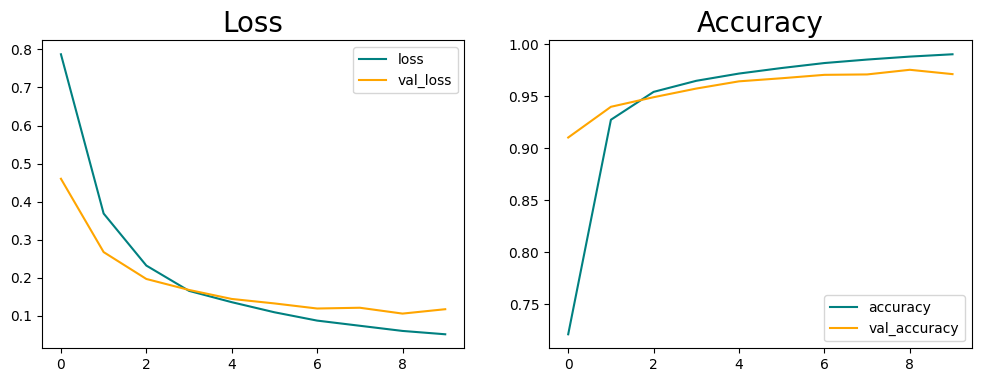

In [40]:
#11. Training Results
#(A). Plot Graph Loss and Accuracy
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot Loss
axes[0].plot(history.history['loss'], color='teal', label='loss')
axes[0].plot(history.history['val_loss'], color='orange', label='val_loss')
axes[0].set_title('Loss', fontsize=20)
axes[0].legend()

# Plot Accuracy
axes[1].plot(history.history['accuracy'], color='teal', label='accuracy')
axes[1].plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
axes[1].set_title('Accuracy', fontsize=20)
axes[1].legend()

plt.show()

In [43]:
#(B) Checking F1-Score inside the classification report
from sklearn.metrics import classification_report

y_pred = model.predict(X_test_padded, batch_size=256, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

40/40 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2378
           1       0.98      0.98      0.98      1750
           2       0.97      0.96      0.96      2082
           3       0.97      0.98      0.97      3875

    accuracy                           0.97     10085
   macro avg       0.97      0.97      0.97     10085
weighted avg       0.97      0.97      0.97     10085



In [44]:
#10. Test Model
#(A) Have an example input
text_string = r'''SAMSUNG SMART TV 50" , 58" , 70" UA50TU8000, UA70TU7000, UA58TU7000KXXM 4K UHD SMART TV 2021'''

#(B) Apply the preprocessing to the string (convert to tokens > padding > embedding (don't need because it's in the model))
# Convert to tokens
test_token = tokenizer.texts_to_sequences(text_string)


In [45]:
# Create a function to remove the empty arrays
def remove_empty(tokens):
    temp = []
    for i in tokens:
        if i != []:
            temp.append(i[0])
    return temp

test_token_processed = np.expand_dims(np.array(remove_empty(test_token)), axis = 0)
test_token_processed.shape

(1, 70)

In [46]:
# Perform padding
test_token_padded = pad_sequences(test_token_processed, maxlen=max_length, padding='post',truncating="post")

In [47]:
#(C) Perform prediction using the model
y_pred = np.argmax(model.predict(test_token_padded))
print(y_pred)

# Use the label encoder to find the class
class_prediction = label_encoder.inverse_transform(y_pred.flatten())
print(class_prediction)

2
['Electronics']


In [48]:
#11. Save the important component so that we can deploy them in another application
# (A) Label Encoder
label_encoder_save_path = "label_encoder.json"
with open(label_encoder_save_path, 'w') as f:
    json.dump(label_encoder.classes_.tolist(), f)

# (B) Tokenizer
tokenizer_save_path = 'tokenizer.pkl'
with open(tokenizer_save_path,"wb") as f:
    pickle.dump(tokenizer, f)

# (C) Keras model
model.save(os.path.join('models', 'category_classify.h5'))

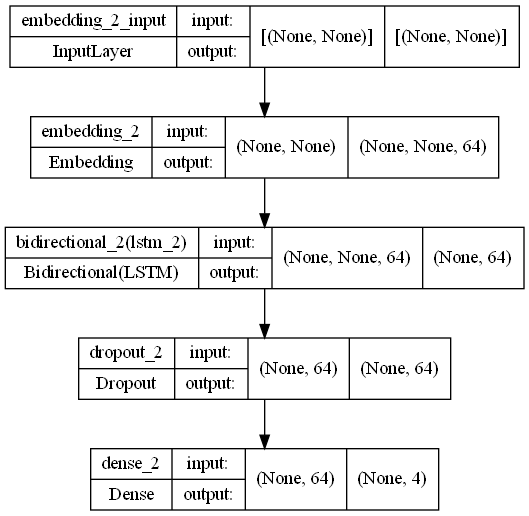

In [49]:
#12.Save the Model Architecture
architecture_path = os.path.join('models', 'model_architecture.png')
tf.keras.utils.plot_model(model, to_file=architecture_path, show_shapes=True, show_layer_names=True)